In [78]:
import ast
import gc
import glob
import json
import os
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import torch
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"
import sys
from functools import partial

sys.path.append("/app/_data/MONAI")
import monai
from monai import data, transforms
from monai.config import print_config
from monai.data import NibabelWriter, decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR, UNet
from monai.transforms import (
    Activations,
    AddChanneld,
    AsDiscrete,
    Compose,
    CropForegroundd,
    Lambdad,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandFlipd,
    RandRotate90d,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
    Transposed,
)
from monai.utils.enums import MetricReduction

In [2]:
df = pd.read_csv("/app/_data/folds.csv")

wrong1 = "case7_day0"
wrong2 = "case81_day30"
df = df[~df["id"].str.contains(wrong1) & ~df["id"].str.contains(wrong2)].reset_index(
    drop=True
)

In [3]:
df = df.sort_values("id").reset_index(drop=True)

In [4]:
FOLD = 1
train_data, val_data = [], []
for case_day, group_df in df[df["fold"] != FOLD].groupby(["case", "day"]):
    group_df = group_df.reset_index(drop=True)
    imgs, labels = [], []
    for ix in group_df.index:
        imgs.append(group_df.loc[ix, "img_npy"])
        labels.append(group_df.loc[ix, "mask_npy"])
    train_data.append({"image": imgs, "label": labels})
for case_day, group_df in df[df["fold"] == FOLD].groupby(["case", "day"]):
    group_df = group_df.reset_index(drop=True)
    imgs, labels = [], []
    for ix in group_df.index:
        imgs.append(group_df.loc[ix, "img_npy"])
        labels.append(group_df.loc[ix, "mask_npy"])
    val_data.append({"image": imgs, "label": labels})

In [5]:
IMG_SIZE = (384, 384, 144)
BATCH_SIZE = 2

In [6]:
# for transform shape must be c, h, w, d
h, w, d = IMG_SIZE
train_transforms = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(
            keys=["image", "label"]
        ),  # d, h, w for img and d, h, w, c for label
        monai.transforms.Transposed(
            keys="label", indices=[3, 1, 2, 0]
        ),  # d, h, w, c to c, h, w, d
        monai.transforms.AddChanneld(keys="image"),  # d, h, w to c, d, h, w
        monai.transforms.Transposed(
            keys="image", indices=[0, 2, 3, 1]
        ),  # c, d, h, w to c, h, w, d
        monai.transforms.SpatialPadd(
            keys=["image", "label"], spatial_size=(h, w, -1)
        ),  # simmetric pad to (c, h, w, d)
        monai.transforms.SpatialPadd(
            keys=["image", "label"], spatial_size=(-1, -1, d), method="end"
        ),  # pad with zero images and masks if depth less then 144 at the end
        monai.transforms.RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        monai.transforms.RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        monai.transforms.RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        monai.transforms.RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        monai.transforms.RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        monai.transforms.OneOf(
            [
                monai.transforms.RandGridDistortiond(
                    keys=["image", "label"],
                    prob=0.5,
                    distort_limit=(-0.05, 0.05),
                    mode="nearest",
                    padding_mode="zeros",
                ),
                monai.transforms.RandAffined(
                    keys=["image", "label"],
                    prob=0.5,
                    rotate_range=np.pi / 12,
                    translate_range=(h * 0.0625, h * 0.0625),
                    scale_range=(0.1, 0.1),
                    mode="nearest",
                    padding_mode="zeros",
                ),
            ],
        ),
        monai.transforms.Lambdad(
            keys="image", func=lambda x: x / x.max()
        ),  # normalize to [0, 1] range
        monai.transforms.EnsureTyped(keys=["image", "label"], dtype=torch.float32),
    ]
)

val_transforms = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(
            keys=["image", "label"]
        ),  # d, h, w for img and d, h, w, c for label
        monai.transforms.Transposed(
            keys="label", indices=[3, 1, 2, 0]
        ),  # d, h, w, c to c, h, w, d
        monai.transforms.AddChanneld(keys="image"),  # d, h, w to c, d, h, w
        monai.transforms.Transposed(
            keys="image", indices=[0, 2, 3, 1]
        ),  # c, d, h, w to c, h, w, d
        monai.transforms.SpatialPadd(
            keys=["image", "label"], spatial_size=(h, w, -1)
        ),  # simmetric pad to (c, 384, 384, d)
        monai.transforms.SpatialPadd(
            keys=["image", "label"], spatial_size=(-1, -1, d), method="end"
        ),  # pad with zero images and masks if depth less then 144 at the end
        monai.transforms.Lambdad(
            keys="image", func=lambda x: x / x.max()
        ),  # normalize to [0, 1] range
        monai.transforms.EnsureTyped(keys=["image", "label"], dtype=torch.float32),
    ]
)

In [7]:
train_ds = data.CacheDataset(
    data=train_data,
    transform=train_transforms,
    cache_num=8,
    cache_rate=1.0,
    num_workers=0,
)
val_ds = data.CacheDataset(
    data=val_data,
    transform=val_transforms,
    cache_num=8,
    cache_rate=1.0,
    num_workers=0,
)

Loading dataset: 100% 8/8 [00:03<00:00,  2.56it/s]
Loading dataset: 100% 8/8 [00:02<00:00,  2.68it/s]


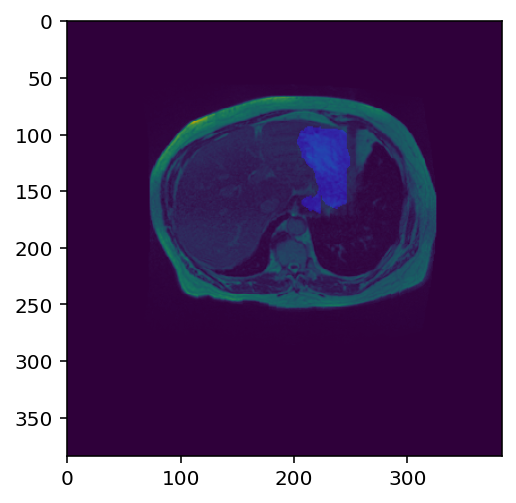

In [8]:
ix = 2
img = train_ds[ix]
i = 49
plt.imshow(img["image"].numpy()[0, :, :, i])
plt.imshow(img["label"].numpy()[:, :, :, i].transpose(1, 2, 0), alpha=0.3)
plt.show();

In [9]:
train_loader = monai.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True
)
val_loader = monai.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True
)

## model

In [10]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# model = monai.networks.nets.SwinUNETR(
#     img_size=IMG_SIZE,
#     in_channels=1,
#     out_channels=3,
#     depths=(2, 2, 2, 2),
#     num_heads=(3, 6, 12, 24),
#     feature_size=24,
#     norm_name="instance",
#     drop_rate=0.05,
#     attn_drop_rate=0.05,
#     dropout_path_rate=0.0,
#     normalize=True,
#     use_checkpoint=True,
#     spatial_dims=3,
# ).to(device)

In [12]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    kernel_size=3,
    up_kernel_size=3,
    num_res_units=2,
    act="PRELU",
    norm="INSTANCE",
    dropout=0.1,
    bias=True,
    dimensions=None,
).to(device)

loss_function = monai.losses.DiceLoss(
    sigmoid=True,
    smooth_nr=0.01,
    smooth_dr=0.01,
    include_background=True,
    batch=True,
    squared_pred=True,
)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [13]:
def create_checkpoint(model, optimizer, epoch, scheduler=None, scaler=None):
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
    }

    if scheduler is not None:
        checkpoint["scheduler"] = scheduler.state_dict()

    if scaler is not None:
        checkpoint["scaler"] = scaler.state_dict()
    return checkpoint

In [14]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10000,
    eta_min=0.00001,
)
dice_metric = monai.metrics.DiceMetric(
    include_background=False, reduction="mean", ignore_empty=False
)

In [19]:
def validate(model, val_loader, device, epoch, img_size):
    model.eval()
    val_bar = tqdm(
        enumerate(val_loader),
        total=len(val_loader),
        desc=f"Val:   epoch #{epoch + 1}",
    )
    with torch.no_grad():
        for step, batch in val_bar:
            val_inputs, val_labels = batch["image"].to(device), batch["label"].to(
                device
            )
            val_outputs = sliding_window_inference(val_inputs, img_size, 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
        val_bar.set_postfix(
            dice=f"{dice_metric:0.4f}",
        )
    return mean_dice_val

In [16]:
def train(model, train_loader, optimizer, scheduler, device, loss_fn, n_epoch, path):
    train_losses, val_dices = [], []
    best_dice = 0
    best_epoch = 0
    scores = {"dice": [], "hd": [], "mean_score": []}
    for epoch in range(n_epoch):
        epoch_loss = train_one_epoch(
            model, train_loader, optimizer, scheduler, device, loss_fn, epoch
        )
        torch.save(model.state_dict(), os.path.join(path, "last.pth"))

        if epoch % 2 == 0:
            mean_val_dice = validate(model, val_loader, device, epoch, img_size)
            val_dices.append([epoch, mean_val_dice])
            if mean_dice_val > best_dice:
                best_epoch = epoch
                torch.save(model.state_dict(), os.path.join(path, "best_dice.pth"))
                print(
                    f"Dice improved from {best_dice:0.4f} to {mean_dice_val:0.4f}, model was saved at {os.path.join(path, 'best_dice.pth')}"
                )
                best_dice = mean_dice_val
        torch.save(model.state_dict(), os.path.join(path, "last.pth"))
        return

In [18]:
def train_one_epoch(model, train_loader, optimizer, scheduler, device, loss_fn, epoch):
    model.train()
    running_loss = 0
    train_bar = tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f"Train: epoch #{epoch + 1}",
        dynamic_ncols=True,
    )
    for step, batch in train_bar:
        step += 1
        optimizer.zero_grad()
        x, y = batch["image"].to(device), batch["label"].to(device)
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        current_lr = optimizer.param_groups[0]["lr"]
        memory = torch.cuda.memory_reserved() / 1e9 if torch.cuda.is_available() else 0
        train_bar.set_postfix(
            train_loss=f"{running_loss/step:0.4f}",
            lr=f"{current_lr:0.6f}",
            gpu_memory=f"{memory:0.2f} GB",
        )
    scheduler.step()
    return running_loss / step

In [91]:
model = model.train()
running_loss = 0
step = 0
best_dice = 0
global_step_best = 0
train_bar = tqdm(
    enumerate(train_loader),
    total=len(train_loader),
    desc=f"Train: step #{step + 1}",
    dynamic_ncols=True,
)
for step, batch in train_bar:
    step += 1
    optimizer.zero_grad()
    x, y = batch["image"].to(device), batch["label"].to(device)
    logits = model(x)
    loss = loss_function(logits, y)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()

    if running_loss != running_loss:
        break
    current_lr = optimizer.param_groups[0]["lr"]
    memory = torch.cuda.memory_reserved() / 1e9 if torch.cuda.is_available() else 0
    train_bar.set_postfix(
        train_loss=f"{running_loss/step:0.4f}",
        lr=f"{current_lr:0.6f}",
        gpu_memory=f"{memory:0.2f} GB",
    )
    torch.cuda.empty_cache()

Train: step #1: 100% 115/115 [07:44<00:00,  4.04s/it, gpu_memory=18.96 GB, lr=0.001000, train_loss=0.9192]


In [30]:
def validate(model, val_loader, device, epoch, img_size):
    model.eval()
    val_bar = tqdm(
        enumerate(val_loader),
        total=len(val_loader),
        desc=f"Val:   epoch #{epoch + 1}",
    )
    with torch.no_grad():
        for step, batch in val_bar:
            val_inputs, val_labels = batch["image"].to(device), batch["label"].to(
                device
            )
            val_outputs = sliding_window_inference(val_inputs, img_size, 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
        val_bar.set_postfix(
            dice=f"{dice_metric:0.4f}",
        )
    return mean_dice_val

In [84]:
def validate(model, val_loader, device, epoch, img_size):
    post_pred = Compose(
        [
            Activations(sigmoid=True),
            AsDiscrete(threshold=0.5),
        ]
    )
    dice = 0
    hd = 0
    weightad_score = 0
    model.eval()

    val_bar = tqdm(
        enumerate(val_loader),
        total=len(val_loader),
        desc=f"Val:   epoch #{epoch + 1}",
    )

    for step, batch in val_bar:
        val_inputs, val_labels = batch["image"].to(device), batch["label"].to(device)
        with torch.no_grad():
            val_outputs = sliding_window_inference(val_inputs, img_size, 4, model)
        val_outputs = [post_pred(i) for i in val_outputs]
        val_outputs = torch.stack(val_outputs)
        # metric is slice level put (n, c, h, w, d) to (n, d, c, h, w) to (n*d, c, h, w)
        val_outputs = val_outputs.permute([0, 4, 1, 2, 3]).flatten(0, 1)
        val_labels = val_labels.permute([0, 4, 1, 2, 3]).flatten(0, 1)
        hausdorff_metric(y_pred=val_outputs, y=val_labels)
        dice_metric(y_pred=val_outputs, y=val_labels)
        del val_outputs, val_inputs, val_labels, batch
    dice_score = dice_metric.aggregate().item()
    hausdorff_score = hausdorff_metric.aggregate().item()
    dice_metric.reset()
    hausdorff_metric.reset()
    all_score = dice_score * 0.4 + hausdorff_score * 0.6
    print(
        f"dice_score: {dice_score} hausdorff_score: {hausdorff_score} all_score: {all_score}"
    )
    torch.cuda.empty_cache()
    gc.collect()
    return dice_score, hausdorff_score, all_score

In [92]:
dice_score, hausdorff_score, all_score = validate(model, val_loader, device, 1, img_size = (384,384,144))

Val:   epoch #2: 100% 21/21 [01:06<00:00,  3.17s/it]


dice_score: 0.19450975954532623 hausdorff_score: 0.5551554125990619 all_score: 0.4108971513775676


In [93]:
dice_score, hausdorff_score, all_score 

(0.19450975954532623, 0.5551554125990619, 0.4108971513775676)

In [57]:
post_pred = Compose(
    [
        Activations(sigmoid=True),
        AsDiscrete(threshold=0.5),
    ]
)

In [88]:
model = model.eval()
img_size = (384, 384, 144)
val_bar = tqdm(
    enumerate(val_loader),
    total=len(val_loader),
    desc=f"Val:   epoch #{1}",
)
with torch.no_grad():
    for step, batch in val_bar:
        val_inputs, val_labels = batch["image"].to(device), batch["label"].to(device)
        val_outputs = sliding_window_inference(val_inputs, img_size, 4, model)
        val_labels_list = decollate_batch(val_labels)
        val_labels_convert = val_labels_list
        val_outputs_list = decollate_batch(val_outputs)
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]
        dice_metric(y_pred=val_output_convert, y=val_labels_convert)
    mean_dice_val = dice_metric.aggregate().item()
    dice_metric.reset()

Val:   epoch #1:   0% 0/21 [00:00<?, ?it/s]

tensor([[0.0720, 0.0494, 0.0699],
        [0.1270, 0.1024, 0.0543]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:   5% 1/21 [00:00<00:10,  1.97it/s]

tensor([[0.1172, 0.1033, 0.0386],
        [0.0734, 0.0817, 0.0710]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  10% 2/21 [00:00<00:09,  2.02it/s]

tensor([[0.0555, 0.0953, 0.0446],
        [0.0503, 0.0645, 0.0490]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  14% 3/21 [00:01<00:08,  2.05it/s]

tensor([[0.0407, 0.0864, 0.0570],
        [0.1565, 0.1465, 0.0443]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  19% 4/21 [00:01<00:08,  2.08it/s]

tensor([[0.1409, 0.1112, 0.0390],
        [0.1222, 0.0871, 0.0619]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  24% 5/21 [00:03<00:12,  1.29it/s]

tensor([[0.1082, 0.1995, 0.1014],
        [0.0859, 0.2011, 0.0564]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  29% 6/21 [00:04<00:14,  1.05it/s]

tensor([[0.0853, 0.0932, 0.0534],
        [0.1061, 0.1009, 0.0534]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  33% 7/21 [00:05<00:14,  1.07s/it]

tensor([[0.0695, 0.0915, 0.0539],
        [0.0368, 0.0679, 0.0470]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  38% 8/21 [00:07<00:14,  1.14s/it]

tensor([[0.0260, 0.0244, 0.0390],
        [0.0120, 0.0386, 0.0429]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  43% 9/21 [00:08<00:13,  1.12s/it]

tensor([[0.0079, 0.0348, 0.0388],
        [0.0200, 0.0133, 0.0272]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  48% 10/21 [00:09<00:12,  1.10s/it]

tensor([[0.0456, 0.0686, 0.0460],
        [0.0479, 0.0669, 0.0454]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  52% 11/21 [00:10<00:11,  1.16s/it]

tensor([[0.0408, 0.0450, 0.0415],
        [0.0585, 0.0645, 0.0223]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  57% 12/21 [00:11<00:11,  1.24s/it]

tensor([[0.0743, 0.0599, 0.0245],
        [0.0161, 0.0255, 0.0372]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  62% 13/21 [00:13<00:10,  1.26s/it]

tensor([[0.1096, 0.1047, 0.0406],
        [0.1004, 0.0833, 0.0327]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  67% 14/21 [00:14<00:08,  1.27s/it]

tensor([[0.1069, 0.0858, 0.0302],
        [0.0965, 0.0962, 0.0317]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  71% 15/21 [00:15<00:07,  1.28s/it]

tensor([[0.1105, 0.0817, 0.0399],
        [0.1183, 0.0983, 0.0376]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  76% 16/21 [00:17<00:06,  1.28s/it]

tensor([[0.1335, 0.0409, 0.0362],
        [0.1487, 0.0921, 0.0339]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  81% 17/21 [00:18<00:05,  1.29s/it]

tensor([[0.0901, 0.0466, 0.0203],
        [0.0892, 0.0215, 0.0187]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  86% 18/21 [00:19<00:03,  1.30s/it]

tensor([[0.0926, 0.0910, 0.0399],
        [0.0538, 0.0316, 0.0425]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  90% 19/21 [00:21<00:02,  1.30s/it]

tensor([[0.0301, 0.0351, 0.0428],
        [0.0649, 0.0677, 0.0521]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1:  95% 20/21 [00:22<00:01,  1.30s/it]

tensor([[0.0767, 0.0880, 0.0494],
        [0.0662, 0.1169, 0.0605]], device='cuda:0')
MetaData
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

Applied operations
[]
Is batch?: False

Val:   epoch #1: 100% 21/21 [00:23<00:00,  1.13s/it]


In [89]:
mean_dice_val

0.06713108718395233

In [67]:
from monai.metrics import CumulativeIterationMetric
from monai.metrics.utils import (
    do_metric_reduction,
    get_mask_edges,
    get_surface_distance,
)


class HausdorffScore(CumulativeIterationMetric):
    """
    Modify MONAI's HausdorffDistanceMetric for Kaggle UW-Madison GI Tract Image Segmentation

    """

    def __init__(
        self,
        reduction="mean",
    ) -> None:
        super().__init__()
        self.reduction = reduction

    def _compute_tensor(self, pred, gt):

        return compute_hausdorff_score(pred, gt)

    def aggregate(self):
        """
        Execute reduction logic for the output of `compute_hausdorff_distance`.

        """
        data = self.get_buffer()
        # do metric reduction
        f, _ = do_metric_reduction(data, self.reduction)
        return f


def compute_directed_hausdorff(pred, gt, max_dist):
    if np.all(pred == gt):
        return 0.0
    if np.sum(pred) == 0:
        return 1.0
    if np.sum(gt) == 0:
        return 1.0
    (edges_pred, edges_gt) = get_mask_edges(pred, gt)
    surface_distance = get_surface_distance(
        edges_pred, edges_gt, distance_metric="euclidean"
    )
    if surface_distance.shape == (0,):
        return 0.0
    dist = surface_distance.max()

    if dist > max_dist:
        return 1.0
    return dist / max_dist


def compute_hausdorff_score(pred, gt):

    y = gt.float().to("cpu").numpy()
    y_pred = pred.float().to("cpu").numpy()

    # hausdorff distance score
    batch_size, n_class = y_pred.shape[:2]
    spatial_size = y_pred.shape[2:]
    max_dist = np.sqrt(np.sum([l**2 for l in spatial_size]))
    hd_score = np.empty((batch_size, n_class))
    for b, c in np.ndindex(batch_size, n_class):
        hd_score[b, c] = 1 - compute_directed_hausdorff(y_pred[b, c], y[b, c], max_dist)

    return torch.from_numpy(hd_score)

In [73]:
dice_metric = DiceMetric(reduction="mean")
hausdorff_metric = HausdorffScore(reduction="mean")
metric_function = [dice_metric, hausdorff_metric]

In [74]:
val_outputs0 = [post_pred(i) for i in val_outputs]
val_outputs0 = torch.stack(val_outputs0)
# metric is slice level put (n, c, h, w, d) to (n, d, c, h, w) to (n*d, c, h, w)
val_outputs0 = val_outputs0.permute([0, 4, 1, 2, 3]).flatten(0, 1)
val_masks = val_labels.permute([0, 4, 1, 2, 3]).flatten(0, 1)

hausdorff_metric(y_pred=val_outputs0, y=val_masks)
dice_metric(y_pred=val_outputs0, y=val_masks)

del val_outputs0, val_inputs, val_masks, batch

dice_score = dice_metric.aggregate().item()
hausdorff_score = hausdorff_metric.aggregate().item()
dice_metric.reset()
hausdorff_metric.reset()

tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.000

tensor([[   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   na

In [75]:
dice_score

0.1521187573671341

In [76]:
hausdorff_score

0.4692648565198055

In [31]:
mean_dice_val = validate(model, val_loader, device, 1, img_size=(384, 384, 144))

Val:   epoch #2:   0% 0/21 [00:00<?, ?it/s]


NameError: name 'post_label' is not defined

In [20]:
x = x.detach().cpu().numpy()

In [19]:
# train_bar = tqdm(
#     enumerate(train_loader),
#     total=len(train_loader),
#     desc=f"Train: step #{step + 1}",
#     dynamic_ncols=True,
# )
# for step, batch in train_bar:
#     x, y = batch["image"], batch["label"]
#     print(x.max(), y.max())

In [25]:
[a.min() for a in x]

[0.0, 0.0]

In [21]:
loss_function(model(batch["image"].to(device)), y)

tensor(0.9713, device='cuda:0', grad_fn=<MeanBackward0>)

In [29]:
batch["image"].shape[2:].

torch.Size([384, 384, 144])

In [ ]:
def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "best_metric_model.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best